# Read files and extract information

There is an example of how to read files and extract information from them.

suppose you have some g16log files in a folder like this:

In [1]:
! ls -l ../../tests/test_files/g16log/

total 53656
-rw-r--r-- 1 tmj tmj  190707 Feb 24 10:49 111.log
-rw-r--r-- 1 tmj tmj  727184 Nov  4 20:14 11_Opt.log
-rw-r--r-- 1 tmj tmj   53139 Jan  9 20:53 3_Sp.log
-rw-r--r-- 1 tmj tmj   90534 Mar 13 14:21 C10.log
-rw-r--r-- 1 tmj tmj 8008984 Feb 18 20:12 RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-Anion_From-IP_C-O-190_TS_Opt.log
-rw-r--r-- 1 tmj tmj 1424205 Nov  4 20:14 S_Ph_Ni_TS.log
-rw-r--r-- 1 tmj tmj 1910081 Jan 16 10:24 TS_4cGKps_ll_ad_4-18_6-13_optts_g16.log
-rw-r--r-- 1 tmj tmj   65746 Jan 16 10:28 TS_4cGKps_ll_ad_4-18_6-13_sp_g16.log
-rw-r--r-- 1 tmj tmj 3896697 Jan 15 22:37 TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16.log
-rw-r--r-- 1 tmj tmj 1307536 Jan 16 10:28 TS_ts_guess_FaFxyx_template_4-18_6-13_optts_conf_g16.log
-rw-r--r-- 1 tmj tmj  115650 Mar  5 22:11 anion_0167_opt_g16_nbo_sp.log
-rw-r--r-- 1 tmj tmj  824630 Feb 23 15:53 cation_0371_opt_g16.log
-rw-r--r-- 1 tmj tmj 2064875 Feb 29 16:47 cation_0407_opt_g16.log
-rw-r--r-- 1 tmj tmj  165117 Feb 17 22:09 dsgdb9nsd_000001-3

Looks like chaos? Yes, they are mixture from some different projects. MolOP can help you to read files and extract information from them through universal methods.

In [2]:
from molop import AutoParser
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole  # for better drawing

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400

files = AutoParser("../../tests/test_files/g16log/*.log", n_jobs=1)

MolOP parsing with single thread: 100%|██████████| 64/64 [00:03<00:00, 20.33it/s]
0 files failed to parse, 64 successfully parsed


We can first get the summary of the files. The summary contains the structure information(SMILES) and some key QM information of the files.

In [3]:
print(files.to_summary_df().to_markdown())

|    | parser            | file_path                                                                                                                 | file_name                                                                    | file_format   | version                                    |   frame_index |   charge |   multiplicity | SMILES                                                                                                                                                                                                                            | functional   | basis           | solvent_model   | solvent   |   temperature | status                                                                                                                                                                                                   | is_optimized   |      ZPE |      TCE |      TCH |       TCG |      ZPE-Gas |        E-Gas |        H-Gas |        G-Gas |           sp |     HOMO |     LUM

We concern about the TS in those log files.

In [4]:
TS_files = files.filter_TS()
print(TS_files.to_summary_df().to_markdown())

|    | parser            | file_path                                                                                                                 | file_name                                                                    | file_format   | version                                    |   frame_index |   charge |   multiplicity | SMILES                                                                                           | functional   | basis           | solvent_model   | solvent   |   temperature | status                                                                                                                                                                                                   | is_optimized   |      ZPE |      TCE |      TCH |      TCG |   ZPE-Gas |    E-Gas |    H-Gas |    G-Gas |       sp |     HOMO |     LUMO |     GAP |   first freq | first freq tag   |   second freq | second freq tag   |   S |   S**2 |
|---:|:------------------|:-----------------------

A case with not too many atoms

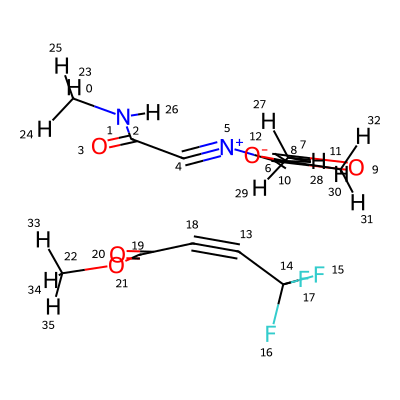

In [5]:
TS_files[2][-1].rdmol

## Orientation standardized

We can get a structure copy with orientation standardized

This method depending on the input `idx_list`, `translate_anchor`, `rotate_anchor_to_X`, and `rotate_anchor_to_XY` are executed in order to obtain the normalized oriented molecule.

Sub-functions:

- `translate_anchor`: Translate the entire molecule so that the specified atom reaches the origin.
- `rotate_anchor_to_X`: Rotate the specified second atom along the axis passing through the origin so that it reaches the positive half-axis of the X-axis.
- `rotate_anchor_to_XY`: Rotate along the axis passing through the origin so that the specified third atom reaches quadrant 1 or 2 of the XY plane.

Input parameters:
                
- If the length of the input `idx_list` is 1, execute `translate_anchor`
- If the length of the input `idx_list` is 2, execute `translate_anchor` and `rotate_anchor_to_X`
- If the length of the input `idx_list` is 3, execute `translate_anchor`, `rotate_anchor_to_X` and `rotate_anchor_to_XY`
- If the length of the input `idx_list` is greater than 3, subsequent atomic numbers are not considered.

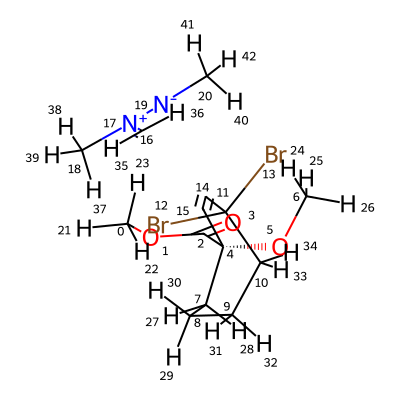

In [6]:
TS_files[3][-1].standard_orient([4, 5, 6]).rdmol

## Atom index reset

Use SMARTS to reset atom index

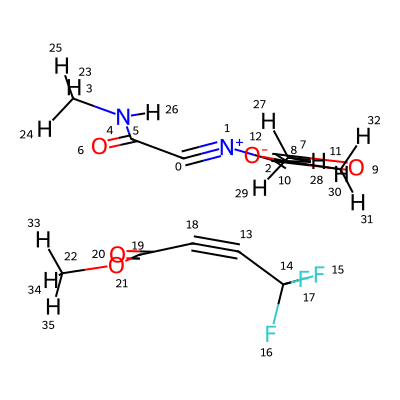

In [7]:
TS_files[2][-1].reset_atom_index("C#[N+]C").rdmol

## Information extraction

The numeric features (like totoal energy)

In [8]:
TS_files[2][-1].energy

{'scf': -1287.3598103 <Unit('hartree / particle')>}

In [9]:
TS_files[2][-1].alpha_energy

{'gap': 0.158160001039505 <Unit('hartree / particle')>,
 'homo': -0.25863 <Unit('hartree / particle')>,
 'lumo': -0.10047 <Unit('hartree / particle')>}

The unit can be transformed to other units powered by [pint](https://pint.readthedocs.io/en/stable/).

In [10]:
TS_files[2][-1].total_energy.to("kcal/mol")

-807830.4774912811 <Unit('kilocalorie / mole')>

The sequential features (like orbitals, freqs)

In [11]:
TS_files[2][-1].alpha_FMO_orbits[:10]

Magnitude,[-24.731969833374023 -24.731029510498047 -24.72835922241211 -19.19597053527832 -19.14518928527832 -19.136709213256836 -19.13656997680664 -19.1346492767334 -14.42477035522461 -14.38012981414795]
Units,hartree/particle


Also offer dimensionless features

In [12]:
TS_files[2][-1].dimensionless_alpha_energy

{'gap': 0.158160001039505, 'homo': -0.25863, 'lumo': -0.10047}

In [13]:
TS_files[2][-1].dimensionless_frequencies[:1]

[{'freq': -300.8307,
  'is imaginary': True,
  'reduced masses': 11.3735,
  'IR intensities': 63.598,
  'force constants': 0.6064,
  'normal coordinates': array([[ 0.08, -0.  , -0.05],
         [ 0.08, -0.05, -0.04],
         [ 0.06, -0.14, -0.  ],
         [ 0.03, -0.04, -0.  ],
         [ 0.03, -0.49, -0.01],
         [-0.04,  0.16,  0.03],
         [-0.13, -0.27,  0.03],
         [-0.03, -0.08,  0.03],
         [ 0.  ,  0.01,  0.02],
         [-0.04, -0.01, -0.02],
         [-0.03, -0.07, -0.01],
         [-0.02, -0.02,  0.01],
         [-0.  ,  0.03,  0.  ],
         [ 0.08,  0.37, -0.02],
         [-0.08,  0.07,  0.  ],
         [-0.04, -0.01,  0.  ],
         [-0.12,  0.08,  0.01],
         [-0.04,  0.  ,  0.  ],
         [ 0.01,  0.54,  0.02],
         [ 0.06,  0.01, -0.  ],
         [ 0.05, -0.05, -0.01],
         [ 0.06, -0.03,  0.01],
         [ 0.05, -0.02,  0.01],
         [ 0.09,  0.01, -0.05],
         [ 0.06,  0.01, -0.04],
         [ 0.1 , -0.  , -0.05],
         [ 0.05

Also support some NBO information

In [14]:
files[10][0].nbo_bond_order

[(0, 1, 2, -1.6547351616 <Unit('hartree / particle')>),
 (0, 2, 1, -1.0358213049999998 <Unit('hartree / particle')>),
 (0, 3, 1, -1.0624234705 <Unit('hartree / particle')>),
 (1, 4, 1, -1.6446143143999998 <Unit('hartree / particle')>),
 (1, 5, 1, -1.6132590705 <Unit('hartree / particle')>),
 (2, 6, 2, -1.2572538084000002 <Unit('hartree / particle')>),
 (2, 7, 1, -0.6566395448000001 <Unit('hartree / particle')>),
 (6, 8, 1, -0.672393609 <Unit('hartree / particle')>),
 (6, 9, 1, -0.6538855232 <Unit('hartree / particle')>)]

In [15]:
files[10][0].nbo_charges

[0.00014,
 0.41537,
 -0.27927,
 -0.10648,
 -0.54078,
 -0.54938,
 -0.52041,
 0.20125,
 0.16487,
 0.21469]

In [16]:
files[10][0].wiberg_bond_order

array([[0.0000e+00, 1.1790e+00, 1.2357e+00, 9.9440e-01, 1.7450e-01,
        1.7140e-01, 8.9600e-02, 6.2000e-03, 1.1200e-02, 8.0000e-04],
       [1.1790e+00, 0.0000e+00, 1.2300e-02, 3.9600e-02, 1.3340e+00,
        1.3004e+00, 5.0400e-02, 7.7000e-03, 2.0000e-04, 3.0000e-04],
       [1.2357e+00, 1.2300e-02, 0.0000e+00, 2.5900e-02, 1.7700e-02,
        1.3000e-02, 1.7359e+00, 9.1430e-01, 5.2000e-03, 5.9000e-03],
       [9.9440e-01, 3.9600e-02, 2.5900e-02, 0.0000e+00, 1.3900e-02,
        3.9300e-02, 1.2800e-02, 6.3000e-03, 7.0000e-04, 2.0000e-04],
       [1.7450e-01, 1.3340e+00, 1.7700e-02, 1.3900e-02, 0.0000e+00,
        2.5330e-01, 6.2100e-02, 1.3000e-03, 6.0000e-04, 1.4000e-03],
       [1.7140e-01, 1.3004e+00, 1.3000e-02, 3.9300e-02, 2.5330e-01,
        0.0000e+00, 6.7600e-02, 1.5000e-03, 4.7000e-03, 8.8000e-03],
       [8.9600e-02, 5.0400e-02, 1.7359e+00, 1.2800e-02, 6.2100e-02,
        6.7600e-02, 0.0000e+00, 7.2000e-03, 9.4950e-01, 9.2490e-01],
       [6.2000e-03, 7.7000e-03, 9.1430e-0

## TS check

MolOP can infer the pre- and post- TS structures from the TS structure with its unique imaginary frequency orientation.

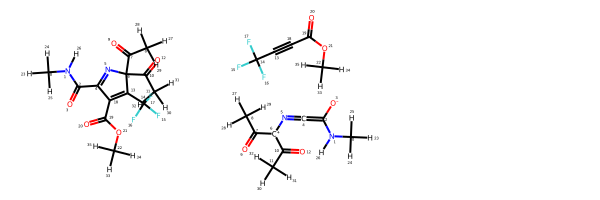

In [17]:
Draw.MolsToGridImage(TS_files[2][-1].possible_pre_post_ts())

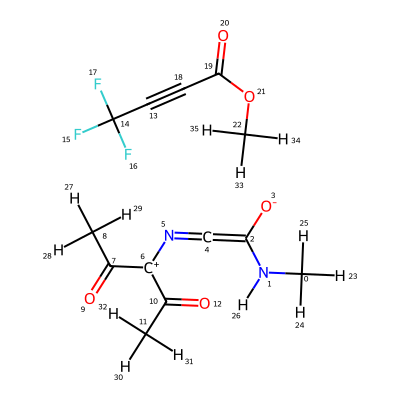

In [18]:
TS_files[2][-1].possible_pre_post_ts()[1]

In [19]:
TS_files[2][-1].imaginary_frequencies

[{'is imaginary': True,
  'freq': -300.8307 <Unit('reciprocal_centimeter')>,
  'reduced masses': 11.3735 <Unit('unified_atomic_mass_unit')>,
  'force constants': 0.6064 <Unit('millidyne / angstrom')>,
  'IR intensities': 63.598 <Unit('kilomole / mole')>,
  'normal coordinates': array([[ 0.08, -0.  , -0.05],
         [ 0.08, -0.05, -0.04],
         [ 0.06, -0.14, -0.  ],
         [ 0.03, -0.04, -0.  ],
         [ 0.03, -0.49, -0.01],
         [-0.04,  0.16,  0.03],
         [-0.13, -0.27,  0.03],
         [-0.03, -0.08,  0.03],
         [ 0.  ,  0.01,  0.02],
         [-0.04, -0.01, -0.02],
         [-0.03, -0.07, -0.01],
         [-0.02, -0.02,  0.01],
         [-0.  ,  0.03,  0.  ],
         [ 0.08,  0.37, -0.02],
         [-0.08,  0.07,  0.  ],
         [-0.04, -0.01,  0.  ],
         [-0.12,  0.08,  0.01],
         [-0.04,  0.  ,  0.  ],
         [ 0.01,  0.54,  0.02],
         [ 0.06,  0.01, -0.  ],
         [ 0.05, -0.05, -0.01],
         [ 0.06, -0.03,  0.01],
         [ 0.05, -0